In [ ]:
pip install pandas numpy scikit-learn matplotlib seaborn joblib scipy


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform
import joblib, time, warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
RANDOM_STATE = 42

In [4]:
DATA_PATH = "covtype.csv"   # change if filename differs
TARGET_COL = "Cover_Type"   # change if your target name differs

df = pd.read_csv(DATA_PATH)
print("Loaded dataframe shape:", df.shape)
display(df.head())
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Edit TARGET_COL accordingly.")


Loaded dataframe shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
print("Missing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))
df = df.dropna().reset_index(drop=True)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)
print("Unique class counts:\n", y.value_counts().sort_index())


Missing values (top 10):
Elevation      0
Soil_Type28    0
Soil_Type17    0
Soil_Type18    0
Soil_Type19    0
Soil_Type20    0
Soil_Type21    0
Soil_Type22    0
Soil_Type23    0
Soil_Type24    0
dtype: int64
Unique class counts:
 Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


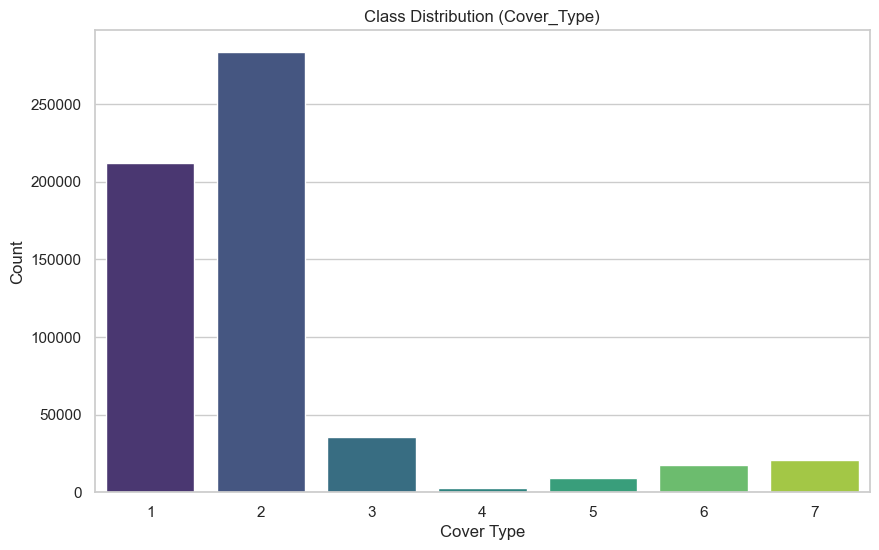

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x=TARGET_COL, data=df, palette='viridis')
plt.title('Class Distribution (Cover_Type)')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()


In [7]:
binary_cols = [c for c in X.columns if set(X[c].dropna().unique()) <= {0,1}]
continuous_cols = [c for c in X.columns if c not in binary_cols]

print(f"Total features: {X.shape[1]}")
print(f"Binary (indicator) cols: {len(binary_cols)}")
print(f"Continuous cols: {len(continuous_cols)}")
print("Example continuous cols:", continuous_cols[:10])


Total features: 54
Binary (indicator) cols: 44
Continuous cols: 10
Example continuous cols: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


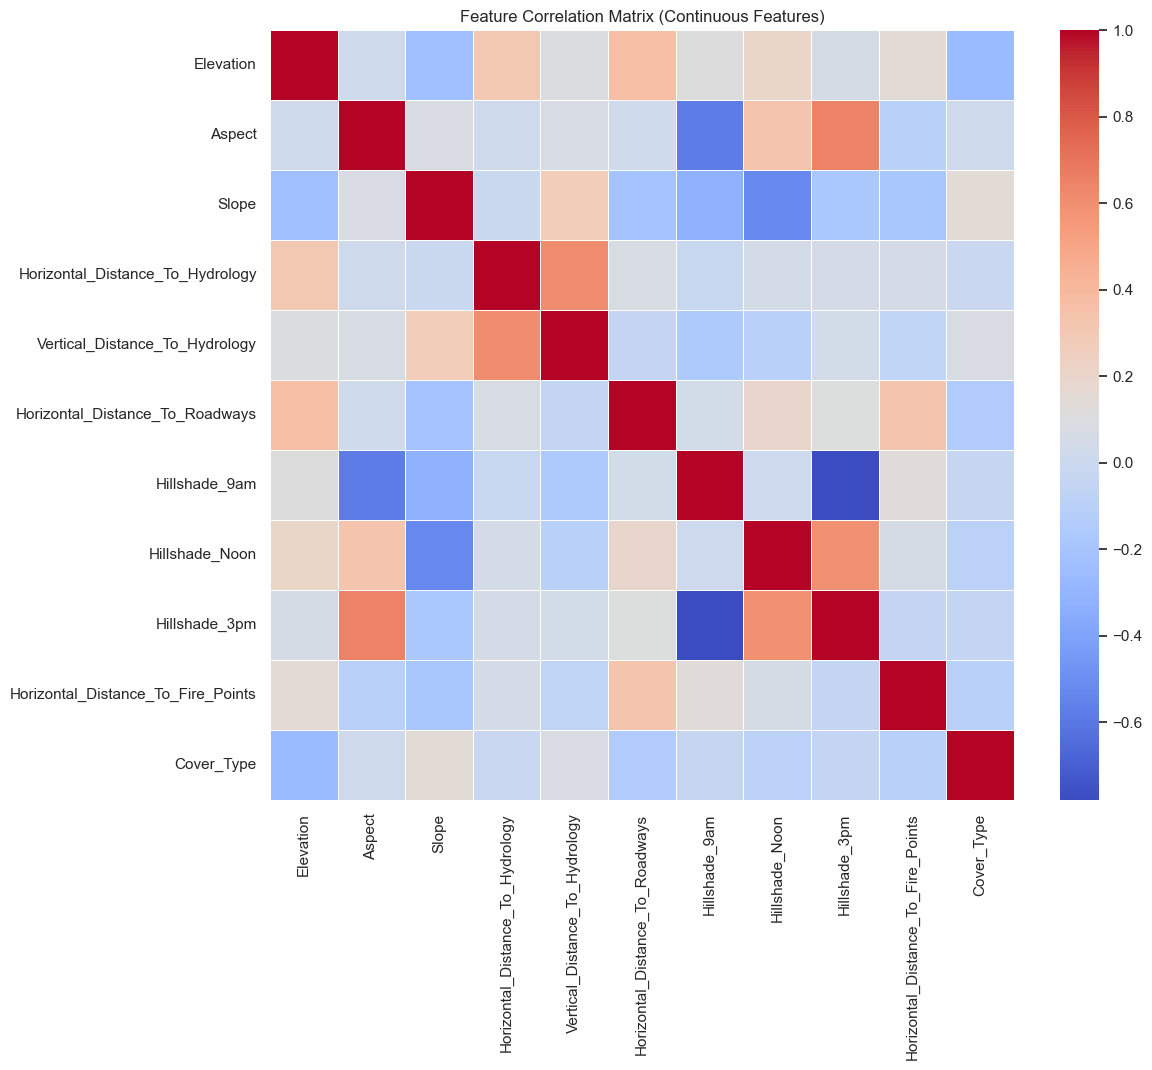

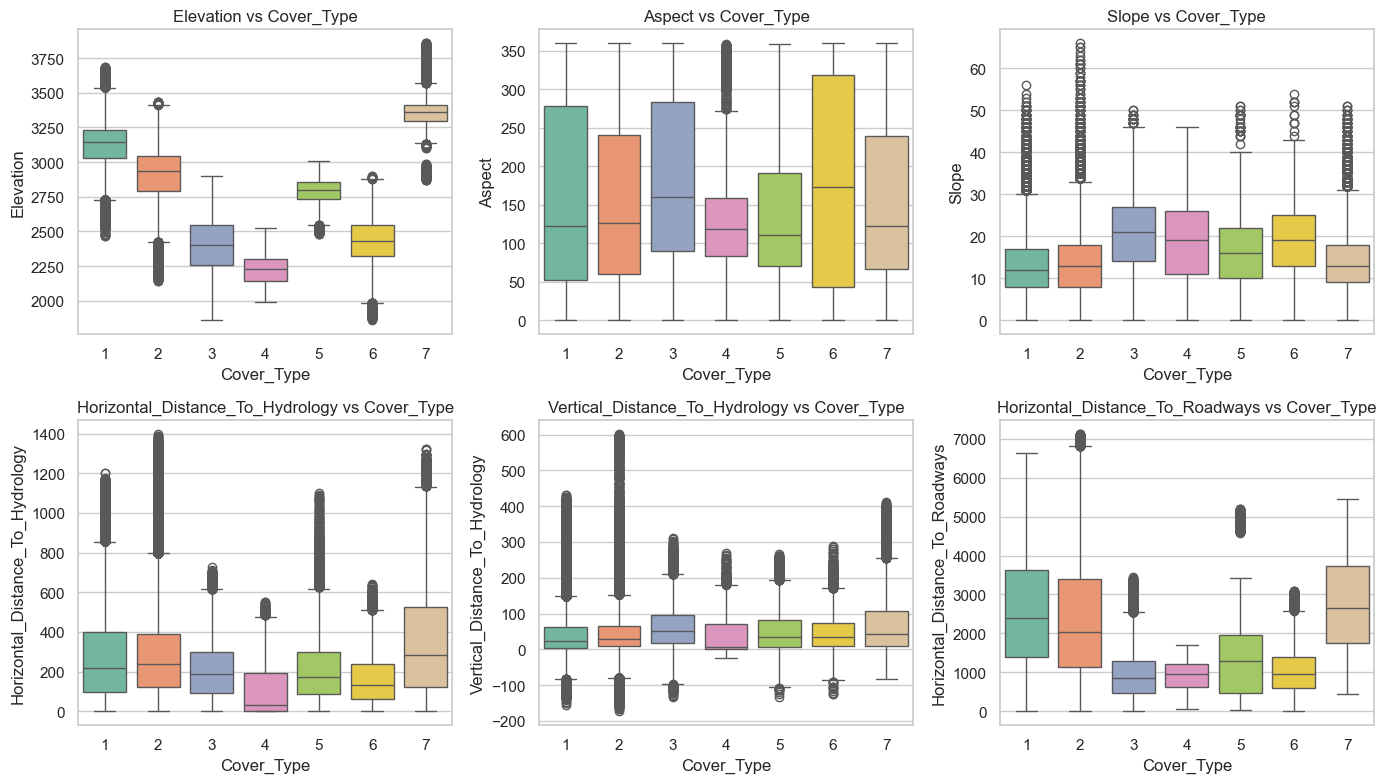

In [8]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df[continuous_cols + [TARGET_COL]].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix (Continuous Features)')
plt.show()

# Boxplots for top continuous features
plt.figure(figsize=(14, 8))
for i, col in enumerate(continuous_cols[:6]): # Show top 6 to avoid clutter
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=TARGET_COL, y=col, data=df, palette='Set2')
    plt.title(f'{col} vs Cover_Type')
plt.tight_layout()
plt.show()


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (464809, 54) Test shape: (116203, 54)


In [10]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

if continuous_cols:
    X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
    X_test_scaled[continuous_cols]  = scaler.transform(X_test[continuous_cols])

X_train_arr = X_train_scaled.values
X_test_arr  = X_test_scaled.values
y_train_arr = y_train.values
y_test_arr  = y_test.values

print("Scaling done. Example (first row):")
display(pd.DataFrame(X_train_arr[:1,:8], columns=X_train_scaled.columns[:8]))


Scaling done. Example (first row):


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon
0,0.755252,0.206925,0.787406,0.003068,0.02712,0.260485,0.406155,1.248611


In [15]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

baseline = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=300,
    early_stopping=True,
    random_state=RANDOM_STATE,
    verbose=False
)

print("Training baseline MLP (may take some minutes)...")
t0 = time.time()
baseline.fit(X_train_arr, y_train_arr)
t1 = time.time()
print(f"Trained baseline in {(t1-t0)/60:.2f} minutes")

y_pred_base = baseline.predict(X_test_arr)
y_prob_base = baseline.predict_proba(X_test_arr)

y_test_bin = label_binarize(y_test_arr, classes=np.unique(y_test_arr))
auc_base = roc_auc_score(y_test_bin, y_prob_base, average='macro')

print("Baseline Accuracy:", accuracy_score(y_test_arr, y_pred_base))
print(f"Baseline Macro AUC: {auc_base:.4f}")

Training baseline MLP (may take some minutes)...
Trained baseline in 3.16 minutes
Baseline Accuracy: 0.9091245492801391
Baseline Macro AUC: 0.9926


In [16]:
# TUNING CONTROLS - edit if you want more/less search
SUBSAMPLE_FRAC = 0.20   # use 0.1-0.3 for quick search; set to 1.0 to use full data
N_ITER = 30             # number of random parameter settings to try
CV_FOLDS = 3
N_JOBS = -1             # -1 uses all processors; set to 1 if memory is limited

# Create subsample for faster search
rng = np.random.RandomState(RANDOM_STATE)
if SUBSAMPLE_FRAC < 1.0:
    n_sub = max(5000, int(len(X_train_arr) * SUBSAMPLE_FRAC))  # ensure at least a few thousand rows
    sub_idx = rng.choice(len(X_train_arr), n_sub, replace=False)
    X_sub = X_train_arr[sub_idx]
    y_sub = y_train_arr[sub_idx]
else:
    X_sub = X_train_arr
    y_sub = y_train_arr

print("Tuning on subsample shape:", X_sub.shape)

# Parameter distributions for RandomizedSearchCV
param_dist = {
    "hidden_layer_sizes": [(64,), (128,), (128,64), (256,128), (256,128,64)],
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "learning_rate_init": [1e-4, 5e-4, 1e-3, 5e-3],
    "activation": ['relu', 'tanh'],
    "batch_size": [64, 128, 256, 'auto']
}

base_mlp = MLPClassifier(solver='adam', early_stopping=True, max_iter=300, random_state=RANDOM_STATE)
cvsplit = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)


Tuning on subsample shape: (92961, 54)


In [17]:
rs = RandomizedSearchCV(
    estimator=base_mlp,
    param_distributions=param_dist,
    n_iter=N_ITER,
    scoring='f1_macro',
    cv=cvsplit,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=2,
    refit=True
)

print("Starting randomized search...")
t0 = time.time()
rs.fit(X_sub, y_sub)
t1 = time.time()
print(f"Random search completed in {(t1-t0)/60:.2f} minutes")
print("Best CV score:", rs.best_score_)
print("Best params:", rs.best_params_)


Starting randomized search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END activation=relu, alpha=0.01, batch_size=128, hidden_layer_sizes=(128,), learning_rate_init=0.0005; total time=  17.8s
[CV] END activation=relu, alpha=0.01, batch_size=128, hidden_layer_sizes=(128,), learning_rate_init=0.0005; total time=  19.4s
[CV] END activation=relu, alpha=0.01, batch_size=256, hidden_layer_sizes=(128, 64), learning_rate_init=0.005; total time=  21.6s
[CV] END activation=relu, alpha=0.01, batch_size=256, hidden_layer_sizes=(128, 64), learning_rate_init=0.005; total time=  22.1s
[CV] END activation=relu, alpha=0.01, batch_size=128, hidden_layer_sizes=(128,), learning_rate_init=0.0005; total time=  26.9s
[CV] END activation=relu, alpha=0.01, batch_size=256, hidden_layer_sizes=(128, 64), learning_rate_init=0.005; total time=  28.4s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=  36.2s
[CV] END acti

In [18]:
best_params = rs.best_params_
best_est = rs.best_estimator_
print("Best estimator summary:")
print(best_est)

# Show top 5 candidates by CV score (optional)
cvres = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').head(5)
display(cvres[['rank_test_score','mean_test_score','std_test_score','params']])


Best estimator summary:
MLPClassifier(activation='tanh', batch_size=64, early_stopping=True,
              hidden_layer_sizes=(256, 128, 64), learning_rate_init=0.0005,
              max_iter=300, random_state=42)


,rank_test_score,mean_test_score,std_test_score,params
10,1,0.833553,0.004871,"{'learning_rate_init': 0.0005, 'hidden_layer_s..."
15,2,0.831825,0.009862,"{'learning_rate_init': 0.0005, 'hidden_layer_s..."
26,3,0.831063,0.006748,"{'learning_rate_init': 0.0005, 'hidden_layer_s..."
4,4,0.826266,0.005858,"{'learning_rate_init': 0.001, 'hidden_layer_si..."
23,5,0.826236,0.005279,"{'learning_rate_init': 0.001, 'hidden_layer_si..."


In [19]:
# If you want a short refinement, uncomment and run the block below.
# It uses RandomizedSearchCV with a narrow grid around the best params.
#
# refine_grid = {
#     "hidden_layer_sizes": [best_params['hidden_layer_sizes'], (int(best_params['hidden_layer_sizes'][0]*1.25),)],
#     "alpha": [best_params['alpha'], best_params['alpha']/5, best_params['alpha']*5],
#     "learning_rate_init": [best_params['learning_rate_init'], best_params['learning_rate_init']/2],
#     "activation": [best_params['activation']],
#     "batch_size": [best_params['batch_size']]
# }
# refiner = RandomizedSearchCV(MLPClassifier(solver='adam', early_stopping=True, max_iter=400, random_state=RANDOM_STATE),
#                             param_distributions=refine_grid, n_iter=8, scoring='f1_macro', cv=cvsplit, n_jobs=N_JOBS, verbose=2, random_state=RANDOM_STATE)
# refiner.fit(X_sub, y_sub)
# print("Refined best params:", refiner.best_params_)
# If used, set best_params = refiner.best_params_


In [20]:
final_mlp = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    solver='adam',
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    batch_size=best_params['batch_size'],
    early_stopping=True,
    max_iter=500,
    random_state=RANDOM_STATE,
    verbose=True
)

print("Training final MLP on full training set (this may take longer)...")
t0 = time.time()
final_mlp.fit(X_train_arr, y_train_arr)
t1 = time.time()
print(f"Final training completed in {(t1-t0)/60:.2f} minutes")


Training final MLP on full training set (this may take longer)...
Iteration 1, loss = 0.53697634
Validation score: 0.815258
Iteration 2, loss = 0.39720163
Validation score: 0.849379
Iteration 3, loss = 0.33527851
Validation score: 0.873540
Iteration 4, loss = 0.29620427
Validation score: 0.884641
Iteration 5, loss = 0.26947000
Validation score: 0.895871
Iteration 6, loss = 0.24965314
Validation score: 0.905811
Iteration 7, loss = 0.23397148
Validation score: 0.908931
Iteration 8, loss = 0.22195635
Validation score: 0.913685
Iteration 9, loss = 0.21164466
Validation score: 0.914761
Iteration 10, loss = 0.20316077
Validation score: 0.916719
Iteration 11, loss = 0.19590270
Validation score: 0.921581
Iteration 12, loss = 0.18875730
Validation score: 0.922248
Iteration 13, loss = 0.18291739
Validation score: 0.926508
Iteration 14, loss = 0.17756071
Validation score: 0.927196
Iteration 15, loss = 0.17318503
Validation score: 0.929326
Iteration 16, loss = 0.16875549
Validation score: 0.930896

In [21]:
y_pred_final = final_mlp.predict(X_test_arr)
y_prob_final = final_mlp.predict_proba(X_test_arr)

acc_final = accuracy_score(y_test_arr, y_pred_final)
y_test_bin = label_binarize(y_test_arr, classes=np.unique(y_test_arr))
auc_final = roc_auc_score(y_test_bin, y_prob_final, average='macro')

print(f"Final Test Accuracy: {acc_final:.4f}")
print(f"Final Test Macro AUC: {auc_final:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test_arr, y_pred_final, digits=4))

Final Test Accuracy: 0.9519
Final Test Macro AUC: 0.9975

Classification Report:

              precision    recall  f1-score   support

           1     0.9480    0.9542    0.9511     42368
           2     0.9610    0.9574    0.9592     56661
           3     0.9372    0.9558    0.9464      7151
           4     0.8994    0.8306    0.8636       549
           5     0.8755    0.8520    0.8636      1899
           6     0.9137    0.8966    0.9051      3473
           7     0.9660    0.9544    0.9601      4102

    accuracy                         0.9519    116203
   macro avg     0.9287    0.9144    0.9213    116203
weighted avg     0.9519    0.9519    0.9519    116203



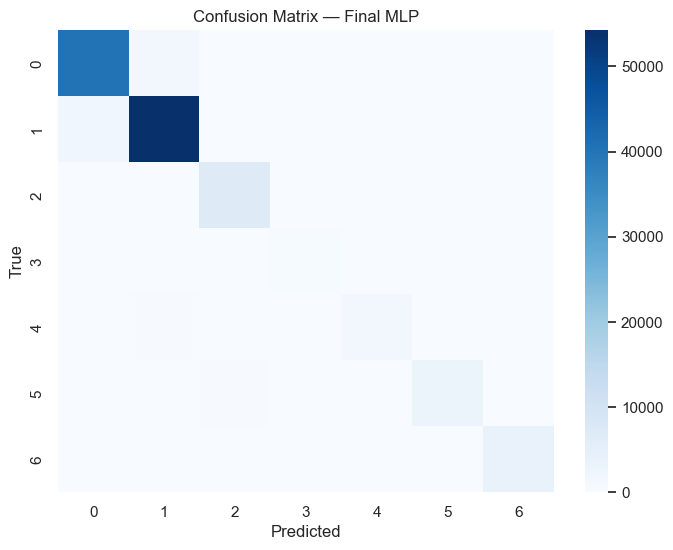

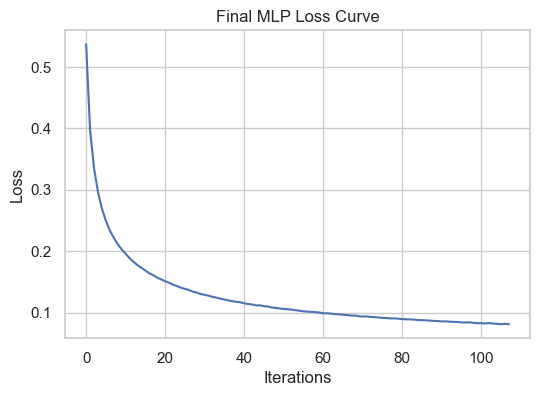

In [22]:
cm = confusion_matrix(y_test_arr, y_pred_final)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Final MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

if hasattr(final_mlp, "loss_curve_"):
    plt.figure(figsize=(6,4))
    plt.plot(final_mlp.loss_curve_)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Final MLP Loss Curve")
    plt.show()


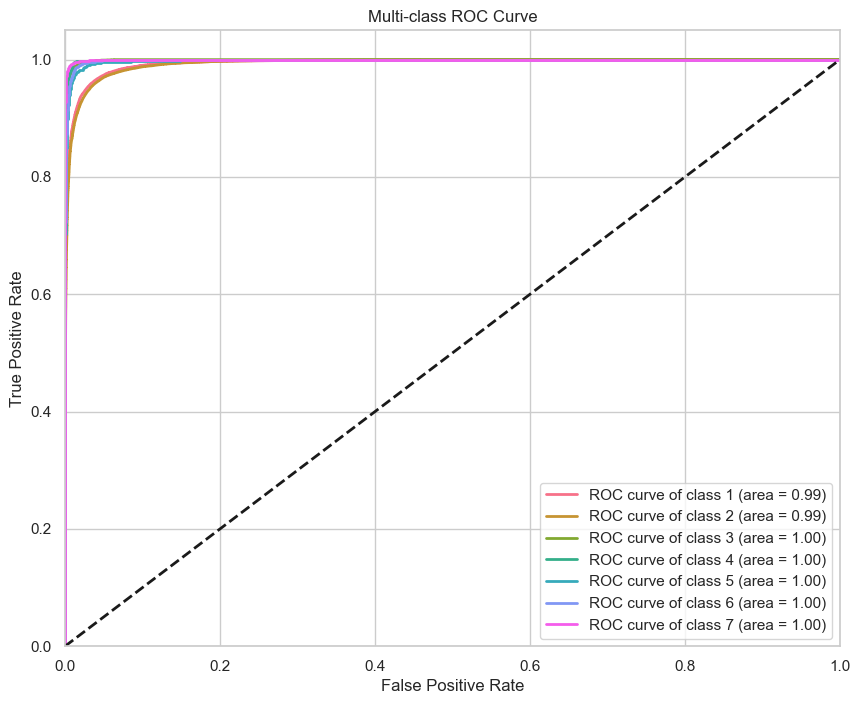

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_test_bin = label_binarize(y_test_arr, classes=np.unique(y_test_arr))
n_classes = y_test_bin.shape[1]

# Get probability estimates
y_score = final_mlp.predict_proba(X_test_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [24]:
import pandas as pd

metrics = {
    "accuracy": [acc_final],
    "auc_score": [auc_final],     # if you're using AUC
    "hidden_layers": [str(final_mlp.hidden_layer_sizes)],
    "activation": [final_mlp.activation],
    "alpha": [final_mlp.alpha],
    "learning_rate_init": [final_mlp.learning_rate_init],
    "batch_size": [final_mlp.batch_size]
}

df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("mlp_model_metrics.csv", index=False)

print("Saved metrics to mlp_model_metrics.csv")


Saved metrics to mlp_model_metrics.csv


In [25]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Use LinearSVC for scalability on large dataset
# Wrap in CalibratedClassifierCV to get predict_proba for AUC
svm = LinearSVC(dual=False, random_state=RANDOM_STATE)
clf_svm = CalibratedClassifierCV(svm)

print("Training SVM (Linear)... this might take a few minutes")
t0 = time.time()
clf_svm.fit(X_train_arr, y_train_arr)
t1 = time.time()
print(f"SVM training completed in {(t1-t0)/60:.2f} minutes")


Training SVM (Linear)... this might take a few minutes
SVM training completed in 0.83 minutes


In [26]:
y_pred_svm = clf_svm.predict(X_test_arr)
y_prob_svm = clf_svm.predict_proba(X_test_arr)

acc_svm = accuracy_score(y_test_arr, y_pred_svm)
auc_svm = roc_auc_score(y_test_arr, y_prob_svm, multi_class='ovr', average='macro')

print(f"SVM Test Accuracy: {acc_svm:.4f}")
print(f"SVM Test Macro AUC: {auc_svm:.4f}")

SVM Test Accuracy: 0.7115
SVM Test Macro AUC: 0.9287


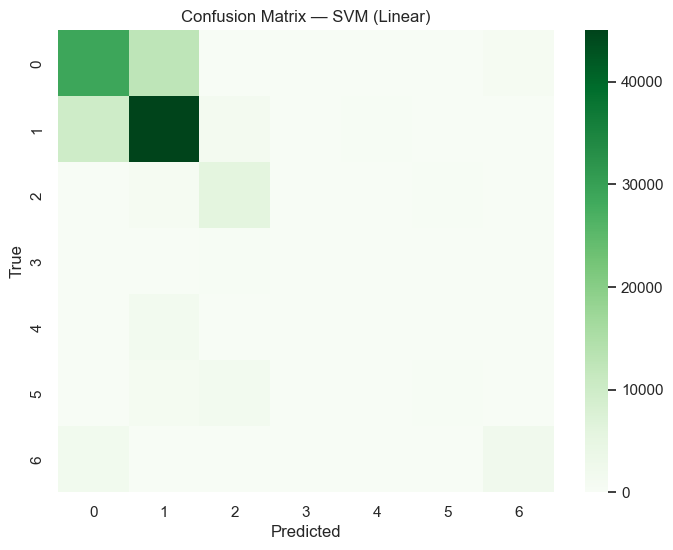

In [28]:
cm_svm = confusion_matrix(y_test_arr, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=False, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — SVM (Linear)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [29]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr = LogisticRegression(random_state=RANDOM_STATE, solver='saga', max_iter=500, n_jobs=-1)

print("Training Logistic Regression... this might take a few minutes")
t0 = time.time()
lr.fit(X_train_arr, y_train_arr)
t1 = time.time()
print(f"LR training completed in {(t1-t0)/60:.2f} minutes")


Training Logistic Regression... this might take a few minutes
LR training completed in 3.14 minutes


In [30]:
y_pred_lr = lr.predict(X_test_arr)
y_prob_lr = lr.predict_proba(X_test_arr)

acc_lr = accuracy_score(y_test_arr, y_pred_lr)
auc_lr = roc_auc_score(y_test_arr, y_prob_lr, multi_class='ovr', average='macro')

print(f"LR Test Accuracy: {acc_lr:.4f}")
print(f"LR Test Macro AUC: {auc_lr:.4f}")


LR Test Accuracy: 0.7235
LR Test Macro AUC: 0.9362


Model Comparison:


,Model,Accuracy,AUC
0,MLP,0.951903,0.997465
1,SVM,0.711539,0.928700
2,Logistic Regression,0.723536,0.936239


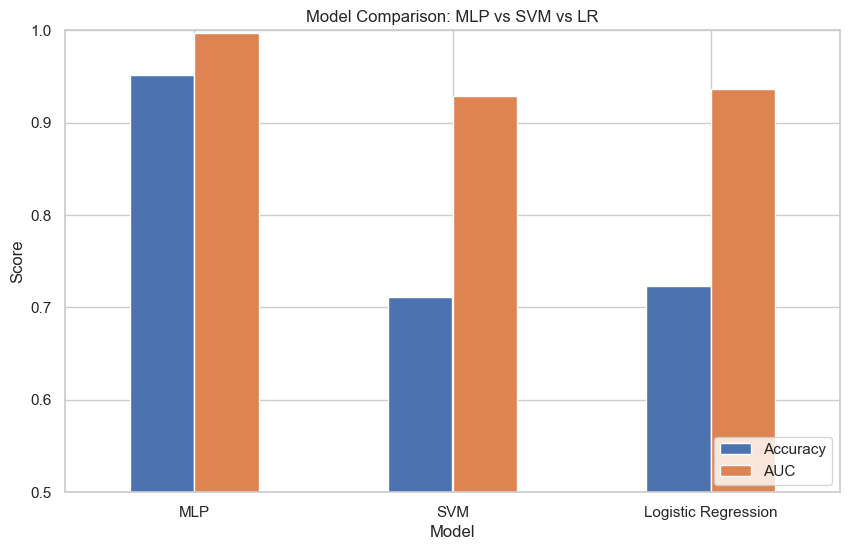

In [31]:
results_df = pd.DataFrame({
    'Model': ['MLP', 'SVM', 'Logistic Regression'],
    'Accuracy': [acc_final, acc_svm, acc_lr],
    'AUC': [auc_final, auc_svm, auc_lr]
})

print("Model Comparison:")
display(results_df)

plt.figure(figsize=(10, 6))
results_df.plot(x='Model', kind='bar', ylim=(0.5, 1.0), rot=0, ax=plt.gca())
plt.title("Model Comparison: MLP vs SVM vs LR")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.show()


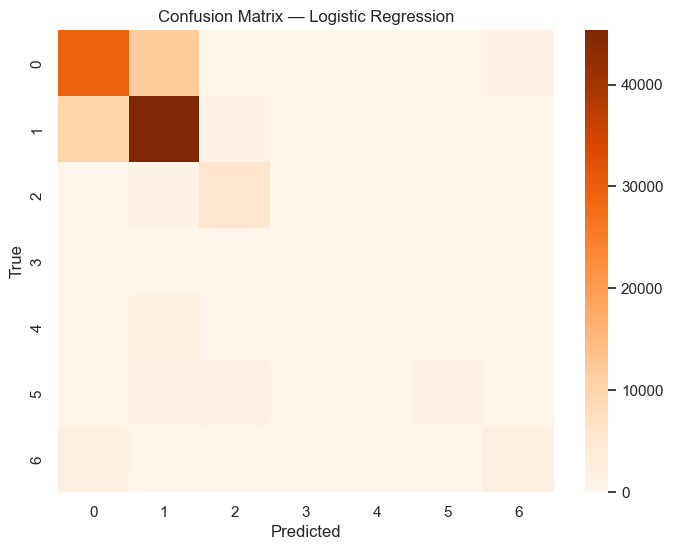

In [32]:
cm_lr = confusion_matrix(y_test_arr, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=False, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
